### Imports

In [1]:
import sys
import os
import random

import torch
import torch.nn as nn
import torch.nn.functional as F
import pandas as pd
import matplotlib.pyplot as plt

from sklearn import metrics
from torch.autograd import Function
from torch.optim import Adam
from graphviz import Source
from pyeda.boolalg.bdd import bdd2expr

filepath = os.path.abspath('')
sys.path.append(os.path.join(filepath, "..", "..", "compiling_nn"))
from build_odd import compile_nn

In [2]:
def plot_cm(y_true, y_pred):
    confusion_matrix = metrics.confusion_matrix(y_true, y_pred)
    cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix, display_labels=[False, True])
    cm_display.plot()

### Networks class and Custom Activation/Loss

In [3]:
class BigNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.nn = nn.Sequential(
            nn.Linear(25,25),
            nn.Sigmoid(),
            nn.Linear(25,5),
            nn.Sigmoid(),
            nn.Linear(5,1),
            StepActivation()
        )

    def forward(self, x):
        x = self.nn(x)
        return x

class SmallNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.nn = nn.Sequential(
            nn.Linear(25,1),
            StepActivation()
        )

    def forward(self, x):
        x = self.nn(x)
        return x
    
######################################################

class StepFunction(Function):
    @staticmethod
    def forward(ctx, input):
        output = torch.where(input>=0, torch.tensor(1.0), torch.tensor(0.0))
        ctx.save_for_backward(input)
        return output
    
    @staticmethod
    def backward(ctx, grad_output):
        input, = ctx.saved_tensors
        grad_input = torch.zeros_like(input)
        return grad_input
    
class StepActivation(nn.Module):
    def forward(self, input):
        if self.training:
            return torch.sigmoid(input)
        else:
            return StepFunction.apply(input)

class ExpLoss(nn.Module): # https://www.desmos.com/calculator/1gtkyr1dlm
    def __init__(self, lower_bound=0, upper_bound=1, b=1.00, base_pow=None, reduction='mean'):
        super(ExpLoss, self).__init__()
        self.coef_div = upper_bound - lower_bound
        self.coef_mul = b
        self.coef_all = self.coef_mul/self.coef_div
        self.base_pow = base_pow

        self.mean_reduction = reduction=='mean'
        self.sum_reduction = reduction=='sum'

    def forward(self, input, label):
        if self.base_pow:
            loss = torch.abs(torch.pow(exponent=(input - label)*self.coef_all, self=self.base_pow) - 1)
        else:
            loss = torch.abs(torch.exp((input - label)*self.coef_all) - 1)

        if self.mean_reduction:
            loss = torch.mean(loss)
        elif self.sum_reduction:
            loss = torch.sum(loss)

        return loss
    
class AsymMSELoss(nn.Module):
    def __init__(self, p=2, reduction='mean'):
        super(AsymMSELoss, self).__init__()
        self.p = p
        self.mean_reduction = reduction == 'mean'

    def forward(self, input, label):
        dif = label - input
        a = torch.square(dif)
        b = a*self.p
        loss = torch.where(dif < 0, b, a)

        if self.mean_reduction:
            loss = torch.mean(loss)
        elif self.sum_reduction:
            loss = torch.sum(loss)

        return loss
    
class TestLoss(Function):
    def __init__(self):
        pass

    def forward(self, input1, input2, label):
        self.save_for_backward(input1, input2, label)
        

    def backward(self, grad_output):
        input1, input2, label = self.saved_tensors

### Data preprocessing

In [4]:
df = pd.read_csv("loan_data_set.csv", sep=",")
df = df.drop(columns=["Loan_ID"])

df_y = pd.get_dummies(df[["Loan_Status"]], drop_first=True)
df_x = df.drop(columns=["Loan_Status"])

nunique = df_x.nunique(axis=0)
df_x_mean = df_x.mean(axis=0, numeric_only=True)

for col, n in nunique.items():
    if n > 4:
        df_x[col] = df_x[col].apply(lambda x : min(4, x//(.5*df_x_mean[col])))

df_x = pd.get_dummies(df_x, columns=df_x.columns, drop_first=True)

itrue = df_y.index[df_y["Loan_Status_Y"]==1].tolist()
ifalse = df_y.index[df_y["Loan_Status_Y"]==0].tolist()

swap = len(itrue) > len(ifalse)
if swap:
    itrue,ifalse=ifalse,itrue

ifalse = random.choices(ifalse, k=len(itrue))

if swap:
    itrue,ifalse=ifalse,itrue

print(df_y.iloc[itrue+ifalse].value_counts())

x=torch.Tensor(df_x.iloc[itrue+ifalse].to_numpy(dtype=int))
y=torch.Tensor(df_y.iloc[itrue+ifalse].to_numpy(dtype=int))

print(x.shape, y.shape)

Loan_Status_Y
0                192
1                192
dtype: int64
torch.Size([384, 25]) torch.Size([384, 1])


### Train Big Network

In [5]:
bignet = BigNet()

max_epoch = 1000
learning_rate = 1e-2

loss_fn = nn.BCELoss()
optimizer = Adam(bignet.parameters(), lr=learning_rate)

for epoch in range(max_epoch):
    bignet.train()
    y_pred = bignet(x)
    loss = loss_fn(y_pred, y)

    bignet.zero_grad()
    loss.backward()
    optimizer.step()

    bignet.eval()
    y_pred_step = bignet(x)
    loss_step = loss_fn(y_pred_step, y)
    if (epoch+1)%50==0:
        print(loss.item(), loss_step.item())

0.6009048819541931 29.42708396911621
0.5255807042121887 25.0
0.4563232958316803 17.44791603088379
0.31873956322669983 10.15625
0.2124469131231308 5.729166507720947
0.13719531893730164 3.3854167461395264
0.0977017879486084 2.6041667461395264
0.08630269765853882 2.6041667461395264
0.08145596832036972 2.6041667461395264
0.07037100940942764 2.34375
0.06619426608085632 2.34375
0.0642039105296135 2.34375
0.06285712867975235 2.34375
0.06185900792479515 2.34375
0.06110299751162529 2.34375
0.060480013489723206 2.34375
0.0599835067987442 2.34375
0.05957074090838432 2.34375
0.059222638607025146 2.34375
0.05894230678677559 2.34375


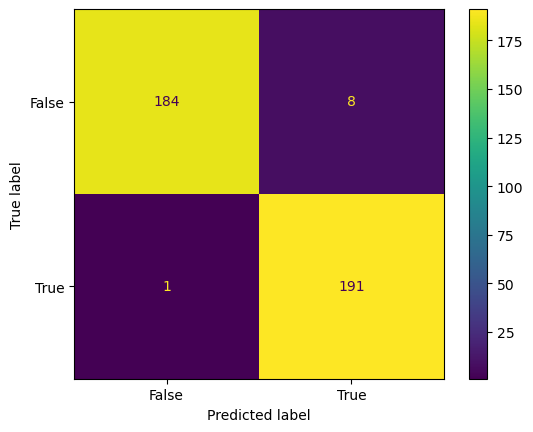

In [6]:
bignet.eval()
y_pred_big = bignet(x).detach().numpy()
plot_cm(y, y_pred_big)
plt.show()

### Train Small Network with Custom Loss (ExpLoss)

In [7]:
smallnet = SmallNet()

max_epoch = 1000
learning_rate = 1e-2

loss_fn_small = ExpLoss(base_pow=1.5, upper_bound=1, lower_bound=0)
optimizer = Adam(smallnet.parameters(), lr=learning_rate)

y_target = torch.maximum(bignet(x), y).detach()

for epoch in range(max_epoch):
    smallnet.train()
    y_pred_small = smallnet(x)
    loss = loss_fn_small(y_pred_small, y_target)

    smallnet.zero_grad()
    loss.backward()
    optimizer.step()

    smallnet.eval()
    y_pred_step_small = smallnet(x)
    loss_step = loss_fn_small(y_pred_step_small, y)
    if (epoch+1)%50==0:
        print(loss.item(), loss_step.item())

0.1724458932876587 0.1666666567325592
0.1538556069135666 0.1189236044883728
0.14180110394954681 0.1154513880610466
0.1345681995153427 0.112413190305233
0.12957243621349335 0.1093749925494194
0.12575548887252808 0.1024305522441864
0.12267863005399704 0.0998263880610466
0.12010755389928818 0.0989583358168602
0.11789324879646301 0.1011284664273262
0.11595030874013901 0.0998263880610466
0.11422738432884216 0.1002604141831398
0.11267933994531631 0.1011284664273262
0.11125969886779785 0.098958320915699
0.10992128401994705 0.098958320915699
0.10862582921981812 0.09765625
0.10737612098455429 0.0941840186715126
0.10621466487646103 0.0954861044883728
0.1051625981926918 0.0933159664273262
0.10420926660299301 0.0933159664273262
0.10333632677793503 0.0924479141831398


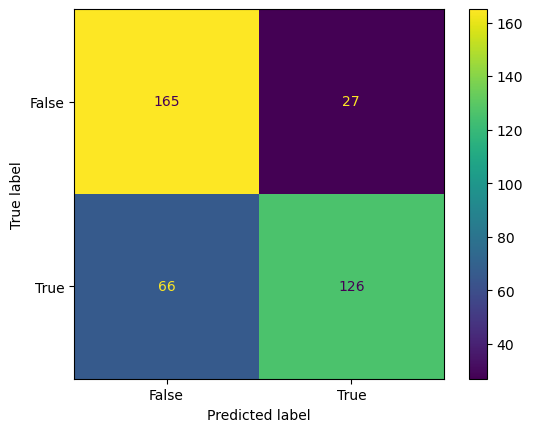

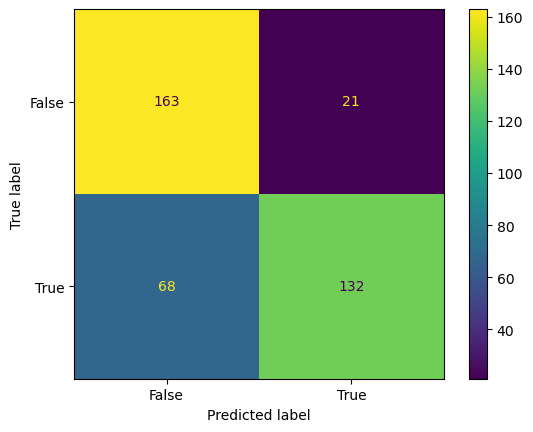

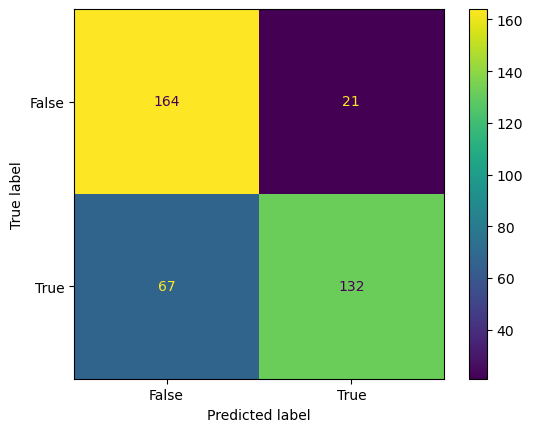

In [8]:
smallnet.eval()
y_pred_small = smallnet(x).detach().numpy()
confusion_matrix_true = metrics.confusion_matrix(y, y_pred_small)
confusion_matrix_target = metrics.confusion_matrix(y_target, y_pred_small)
confusion_matrix_big = metrics.confusion_matrix(y_pred_big, y_pred_small)

cm_display_true   = metrics.ConfusionMatrixDisplay(confusion_matrix_true, display_labels=[False, True])
cm_display_target = metrics.ConfusionMatrixDisplay(confusion_matrix_target, display_labels=[False, True])
cm_display_big    = metrics.ConfusionMatrixDisplay(confusion_matrix_big, display_labels=[False, True])

cm_display_true.plot()
cm_display_target.plot()
cm_display_big.plot()
plt.show()

### Train Small Network with BCELoss

In [9]:
smallnet = SmallNet()

max_epoch = 1000
learning_rate = 1e-2

loss_fn_small = nn.BCELoss()
optimizer = Adam(smallnet.parameters(), lr=learning_rate)

y_target = torch.minimum(bignet(x), y).detach()

for epoch in range(max_epoch):
    smallnet.train()
    y_pred_small = smallnet(x)
    loss = loss_fn_small(y_pred_small, y_target)

    smallnet.zero_grad()
    loss.backward()
    optimizer.step()

    smallnet.eval()
    y_pred_step_small = smallnet(x)
    loss_step = loss_fn(y_pred_step_small, y)
    if (epoch+1)%50==0:
        print(loss.item(), loss_step.item())

0.6034486889839172 35.67708206176758
0.5661311745643616 30.20833396911621
0.5462000966072083 27.86458396911621
0.5348109006881714 25.52083396911621
0.5282700657844543 25.0
0.5244949460029602 23.69791603088379
0.5222873687744141 23.95833396911621
0.5209645628929138 25.0
0.5201432108879089 25.26041603088379
0.5196111798286438 25.52083396911621
0.519252598285675 25.52083396911621
0.5190039277076721 25.52083396911621
0.518828809261322 25.26041603088379
0.5187055468559265 25.26041603088379
0.5186194181442261 25.26041603088379
0.5185602307319641 25.26041603088379
0.5185204744338989 25.26041603088379
0.5184942483901978 25.26041603088379
0.5184773802757263 25.26041603088379
0.5184667110443115 25.26041603088379


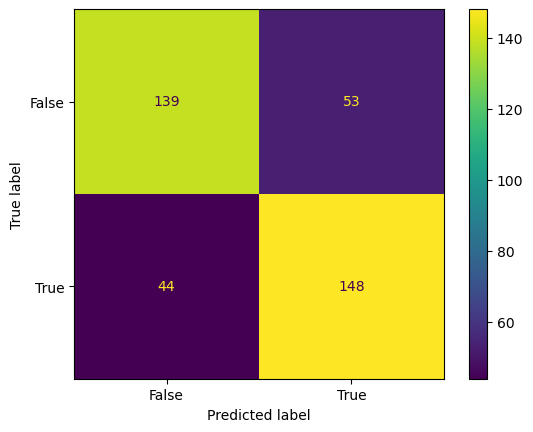

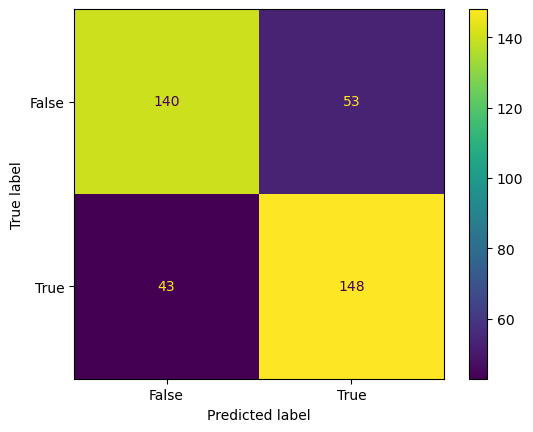

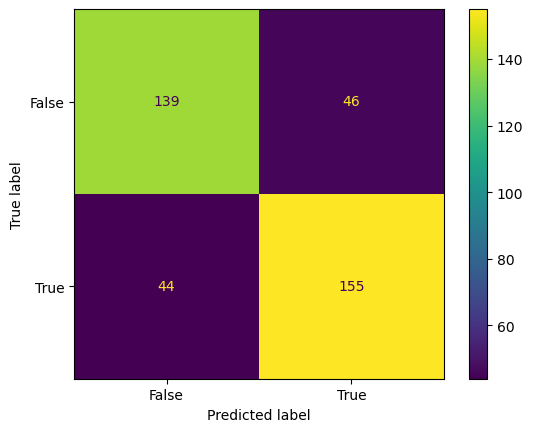

In [10]:
smallnet.eval()
y_pred_small = smallnet(x).detach().numpy()
confusion_matrix_true = metrics.confusion_matrix(y, y_pred_small)
confusion_matrix_target = metrics.confusion_matrix(y_target, y_pred_small)
confusion_matrix_big = metrics.confusion_matrix(y_pred_big, y_pred_small)

cm_display_true   = metrics.ConfusionMatrixDisplay(confusion_matrix_true, display_labels=[False, True])
cm_display_target = metrics.ConfusionMatrixDisplay(confusion_matrix_target, display_labels=[False, True])
cm_display_big    = metrics.ConfusionMatrixDisplay(confusion_matrix_big, display_labels=[False, True])

cm_display_true.plot()
cm_display_target.plot()
cm_display_big.plot()
plt.show()

### Combined training ExpLoss

In [11]:
hi_net = SmallNet()
bignet = BigNet()
lo_net = SmallNet()

max_epoch = 1000
learning_rate = 1e-2

loss_fn_hi = ExpLoss(base_pow=1.4, upper_bound=1, lower_bound=0) # pénalise plus les faux 1 
loss_fn_big= nn.BCELoss()
loss_fn_lo = ExpLoss(base_pow=1.2, upper_bound=0, lower_bound=1) # pénalise plus les faux 0

optimizer1 = Adam(hi_net.parameters(), lr=learning_rate)
optimizer2 = Adam(bignet.parameters(), lr=learning_rate)
optimizer3 = Adam(lo_net.parameters(), lr=learning_rate)

for epoch in range(max_epoch):
    hi_net.train()
    bignet.train()
    lo_net.train()

    y_pred_hi = hi_net(x)
    y_pred_big= bignet(x)
    y_pred_lo = lo_net(x)

    y_target_hi = y_pred_big.detach()
    y_target_lo = y_pred_big.detach()
    # y_target_hi = torch.maximum(y_pred_big.detach(), y)
    # y_target_lo = torch.minimum(y_pred_big.detach(), y)
    loss_hi = loss_fn_hi(y_pred_hi, y_target_hi)
    loss_big= loss_fn_big(y_pred_big, y)
    loss_lo = loss_fn_lo(y_pred_lo, y_target_lo)

    hi_net.zero_grad()
    bignet.zero_grad()
    lo_net.zero_grad()
    loss_hi.backward()
    loss_big.backward()
    loss_lo.backward()
    optimizer1.step()
    optimizer2.step()
    optimizer3.step()

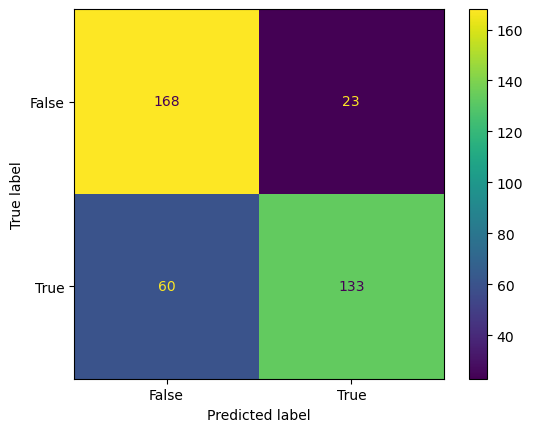

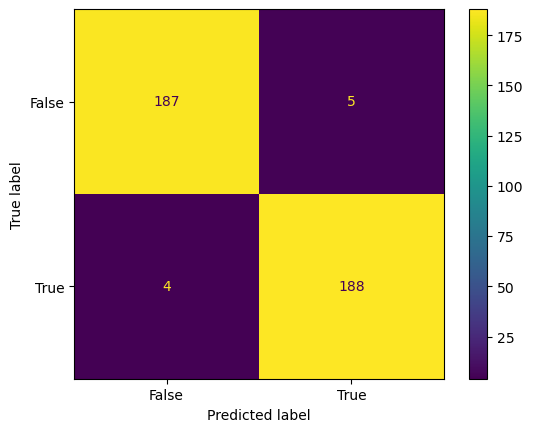

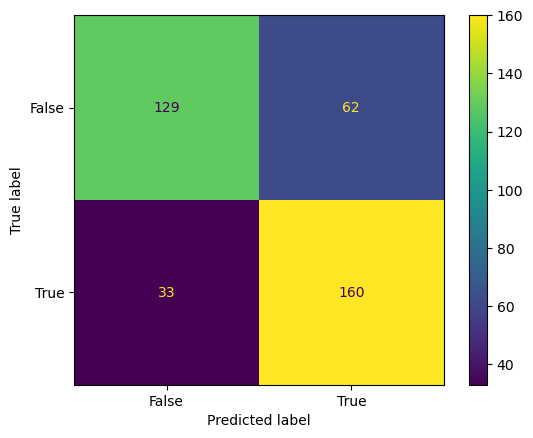

In [12]:
hi_net.eval()
bignet.eval()
lo_net.eval()
y_pred_hi   = hi_net(x).detach().numpy()
y_pred_big  = bignet(x).detach().numpy()
y_pred_lo   = lo_net(x).detach().numpy()
plot_cm(y_pred_big, y_pred_hi)
plot_cm(y, y_pred_big)
plot_cm(y_pred_big, y_pred_lo)
plt.show()

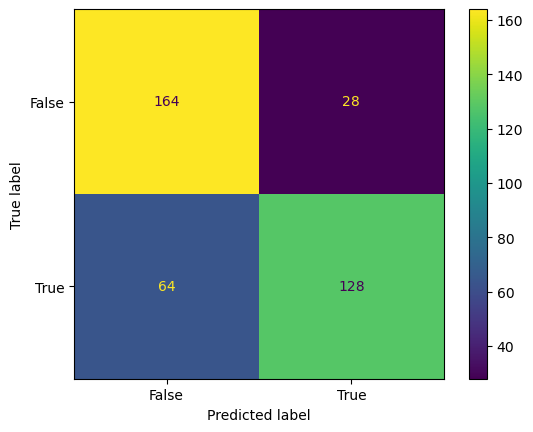

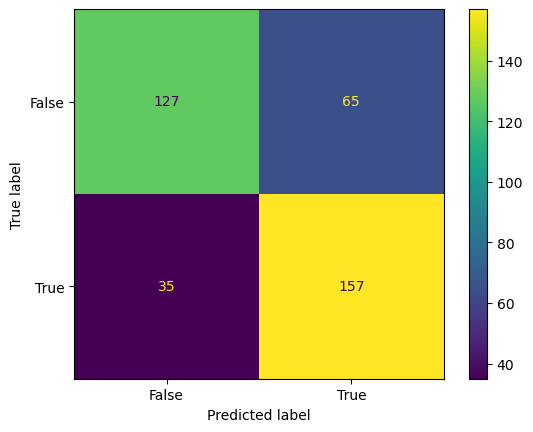

In [13]:
confusion_matrix_hi2 = metrics.confusion_matrix(y, y_pred_hi)
confusion_matrix_lo2 = metrics.confusion_matrix(y, y_pred_lo)

cm_display_hi2   = metrics.ConfusionMatrixDisplay(confusion_matrix_hi2, display_labels=[False, True])
cm_display_lo2   = metrics.ConfusionMatrixDisplay(confusion_matrix_lo2, display_labels=[False, True])

cm_display_hi2.plot()
cm_display_lo2.plot()
plt.show()

### Combined training + small degradation

In [14]:
def tnot(a): return torch.logical_not(a)
def tor(a,b): return torch.logical_or(a,b)
def tand(a,b): return torch.logical_and(a,b)
def txor(a,b): return torch.logical_xor(a,b)

class BNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.hi = nn.Sequential(
            nn.Linear(25,5),
            StepActivation(),
            nn.Linear(5,1),
            StepActivation()
        )
        self.lo = nn.Sequential(
            nn.Linear(25,5),
            StepActivation(),
            nn.Linear(5,1),
            StepActivation()
        )
        self.nn = nn.Sequential(
            nn.Linear(25,25),
            nn.Sigmoid(),
            nn.Linear(25,5),
            nn.Sigmoid(),
            nn.Linear(5,1),
            StepActivation()
        )

    def forward(self, x):
        xhi = self.hi(x)
        xnn = self.nn(x)
        xlo = self.lo(x)

        x = tor(tand(tnot(txor(xhi, xlo)), xhi), tand(txor(xhi, xlo), xnn)).float()
        x.requires_grad=True
        return {"hi": xhi, "nn": xnn, "lo": xlo, "mn": x}

In [37]:
bnet = BNet()

max_epoch = 5000
learning_rate = 1e-2

loss_hi_nn = AsymMSELoss(100)
loss_lo_nn = AsymMSELoss(.001)
loss_nn_tr = nn.BCELoss()

optimizer = Adam(bnet.parameters(), lr=learning_rate)

for epoch in range(max_epoch):
    bnet.train()
    y_pred = bnet(x)
    loss_nn = loss_nn_tr(y_pred["nn"], y)

    y_target = torch.tensor(y_pred["nn"].detach().numpy())
    loss_hi = loss_hi_nn(y_pred["hi"], y_target)
    loss_lo = loss_lo_nn(y_pred["lo"], y_target)
    # loss = loss_nn + loss_hi + loss_lo

    bnet.zero_grad()
    # loss.backward()
    loss_nn.backward()
    loss_hi.backward()
    loss_lo.backward()
    optimizer.step()

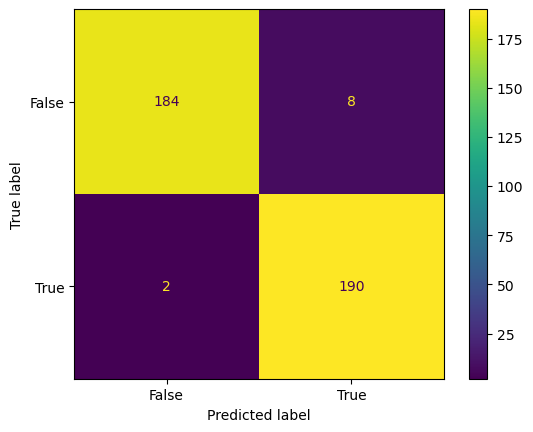

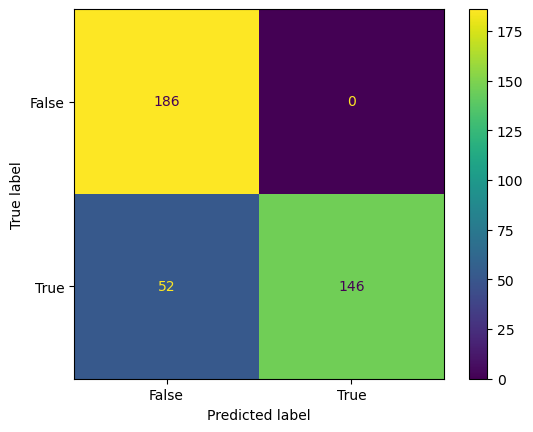

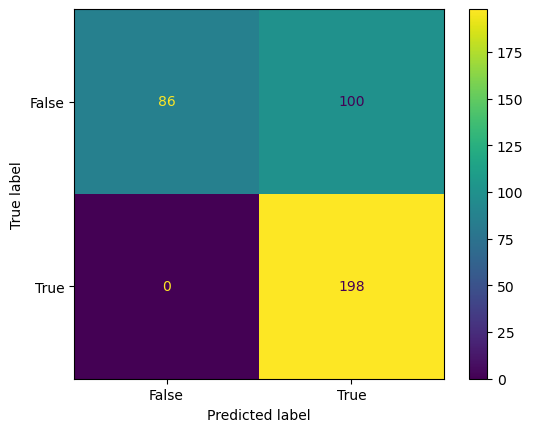

In [41]:
bnet.eval()
y_pred = bnet(x)
y_pred_mn = y_pred["mn"].detach()
y_pred_nn = y_pred["nn"].detach()
y_pred_hi = y_pred["hi"].detach()
y_pred_lo = y_pred["lo"].detach()

# plot_cm(y, y_pred_mn)
plot_cm(y, y_pred_nn)
plot_cm(y_pred_nn, y_pred_hi)
plot_cm(y_pred_nn, y_pred_lo)
plt.show()

In [39]:
iiii = torch.where(torch.logical_and(y_pred_nn == 0, y_pred_hi == 1), torch.full(y_pred_nn.size(), 1), y_pred_nn)
print(torch.logical_and(y_pred_nn == 0, y_pred_hi == 1).nonzero())
oooo = torch.where(torch.logical_and(y_pred_nn == 1, y_pred_lo == 0), torch.full(y_pred_nn.size(), 0), iiii)
print(torch.logical_and(y_pred_nn == 1, y_pred_lo == 0).nonzero())

optimizer = Adam(bnet.nn.parameters(), lr=learning_rate)

for epoch in range(max_epoch):
    bnet.nn.train()
    y_pred = bnet.nn(x)
    loss_nn = loss_nn_tr(y_pred, oooo)

    bnet.nn.zero_grad()
    loss_nn.backward()
    optimizer.step()

tensor([[101,   0],
        [165,   0],
        [301,   0],
        [303,   0],
        [334,   0]])
tensor([], size=(0, 2), dtype=torch.int64)


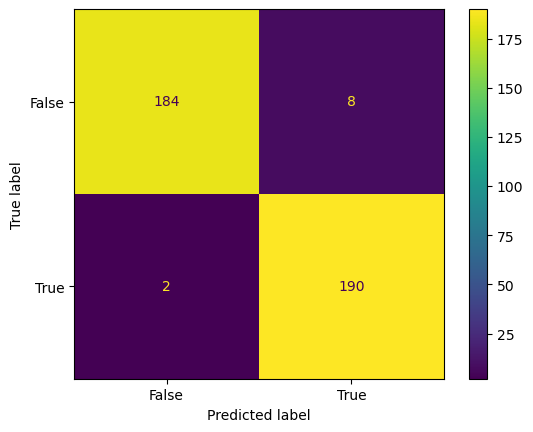

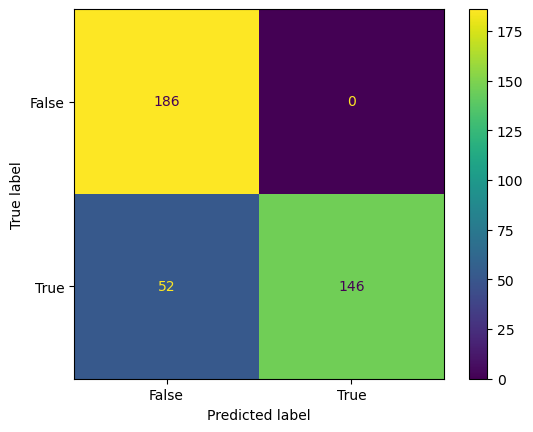

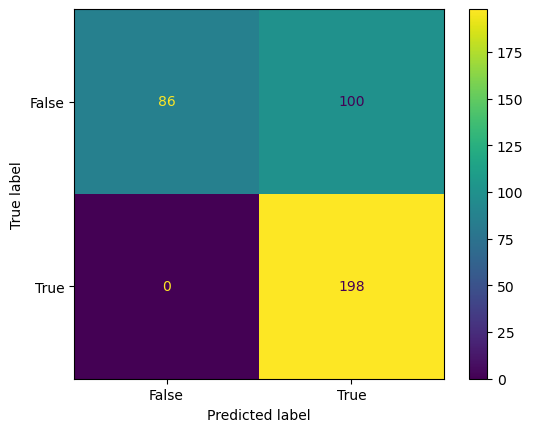

In [42]:
bnet.eval()
y_pred = bnet(x)
y_pred_mn = y_pred["mn"].detach()
y_pred_nn = y_pred["nn"].detach()
y_pred_hi = y_pred["hi"].detach()
y_pred_lo = y_pred["lo"].detach()

# plot_cm(y, y_pred_mn)
plot_cm(y, y_pred_nn)
plot_cm(y_pred_nn, y_pred_hi)
plot_cm(y_pred_nn, y_pred_lo)
plt.show()

### Separated

In [19]:
class HiNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.nn = nn.Sequential(
            nn.Linear(25,5),
            StepActivation(),
            nn.Linear(5,1),
            StepActivation()
        )

    def forward(self, x):
        return self.nn(x)

class LoNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.nn = nn.Sequential(
            nn.Linear(25,5),
            StepActivation(),
            nn.Linear(5,1),
            StepActivation()
        )
    
    def forward(self, x):
        return self.nn(x)

class GrNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.nn = nn.Sequential(
            nn.Linear(25,25),
            nn.Sigmoid(),
            nn.Linear(25,5),
            nn.Sigmoid(),
            nn.Linear(5,1),
            StepActivation()
        )

    def forward(self, x):
        return self.nn(x)

In [20]:
a = HiNet()
b = GrNet()
c = LoNet()

max_epoch = 1000
learning_rate = 1e-2

loss_a = nn.BCELoss()
loss_b = nn.BCELoss()
loss_c = nn.BCELoss()

opti_a = Adam(a.parameters(), lr=learning_rate)
opti_b = Adam(b.parameters(), lr=learning_rate)
opti_c = Adam(c.parameters(), lr=learning_rate)

for epoch in range(max_epoch):
    a.train()
    b.train()
    c.train()

    ya = a(x)
    yb = b(x)
    yc = c(x)

    loss_aa = loss_a(ya, yb.detach())
    loss_bb = loss_b(yb, y)
    loss_cc = loss_c(yc, yb.detach())

    a.zero_grad()
    b.zero_grad()
    c.zero_grad()
    
    loss_aa.backward()
    loss_bb.backward()
    loss_cc.backward()

    opti_a.step()
    opti_b.step()
    opti_c.step()

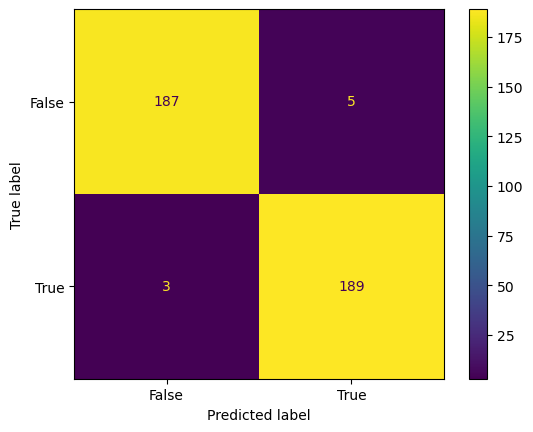

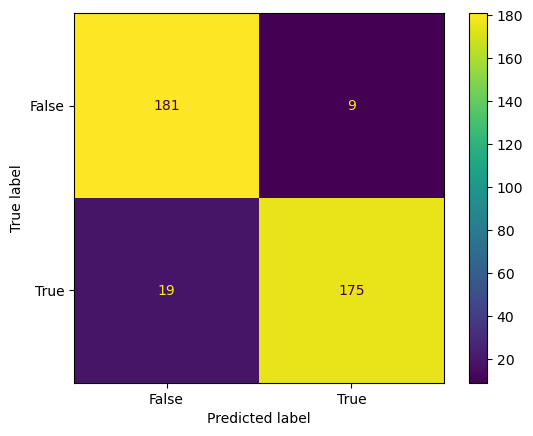

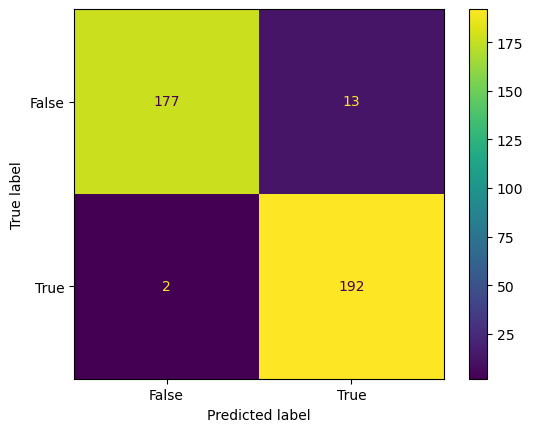

In [21]:
a.eval()
b.eval()
c.eval()

yan = a(x).detach().numpy()
ybn = b(x).detach().numpy()
ycn = c(x).detach().numpy()

plot_cm(y, ybn)
plot_cm(ybn, yan)
plot_cm(ybn, ycn)